In [2]:
import sys
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
#import panns_inference

TUT_CSV = 'Datasets/TUT18_train.csv'
SCAPPER_TRAIN_CSV = 'Datasets/scrapper_train_dataset.csv'
SCAPPER_TEST_CSV = 'Datasets/scrapper_test_dataset.csv'
TUT_AUD_DIR = '../audioData/TUTUrban2018/developmentDataset/TUT-urban-acoustic-scenes-2018-development/'
SCAPPER_AUD_DIR = '../audioData/sythenticSoundscenes/train/'

In [48]:
scapper_df = pd.read_csv(SCAPPER_TEST_CSV)
scapper_scene_labels = (list)(scapper_df['acoustic_scene_label'].unique())

def label_to_one_hot(labels, label_array=scapper_scene_labels):
    """
    Convert string labels to one-hot encoded labels based on the provided array of labels.

    Args:
    - labels (list of str): List of string labels to convert.
    - label_array (numpy array): Array containing all possible labels.

    Returns:
    - one_hot_encoded (numpy array): One-hot encoded labels corresponding to the input labels.
    """
    label_dict = {label: i for i, label in enumerate(label_array)}
    one_hot_encoded = np.zeros((len(labels), len(label_array)), dtype=int)
    for i, label in enumerate(labels):
        if label in label_dict:
            one_hot_encoded[i, label_dict[label]] = 1
    return torch.tensor(one_hot_encoded)

def convert_outputs(outputs):
    new_output = [0. for i in range((outputs.shape[0]))]
    new_output[np.argmax(outputs)] = 1.
    return np.array(new_output)


In [4]:
sys.path.append('Datasets/')
sys.path.append('utils/')
import datasets
import audio_utils

scapper_dataset = datasets.scraperDataset(SCAPPER_TEST_CSV, SCAPPER_AUD_DIR, only_scene=False, transforms=audio_utils.get_log_melSpectrogram)

In [5]:
for i in range(3):
    print(scapper_dataset[i]['data'].shape)

torch.Size([1, 40, 1501])
torch.Size([1, 40, 1501])
torch.Size([1, 40, 1501])


In [6]:
from torch.utils.data import DataLoader

test_loader = DataLoader(scapper_dataset, batch_size=32, shuffle=True)

for i, batch in enumerate(test_loader):
    if i == 0:
        print(label_to_one_hot(batch['scene_label']))
    else:
        break

tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],


In [7]:
import torch.nn.functional as F

class ASC_Model00(nn.Module):
    def __init__(self):
        super(ASC_Model00, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        
        # Pooling layer
        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.relu = nn.ReLU()
        # Output layers
        self.output_layer = nn.Linear(2048, 10)
        self.softmax = nn.Softmax()
        #self.second_last_layer = nn.Linear(2048, 2048)
        
    def forward(self, x):
        # Convolutional layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        
        # Pooling layer
        x = self.pool(x)
        
        # Flatten tensor
        x = x.flatten(start_dim=1)
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        second_last = self.relu(self.fc3(x))
        
        # Output layers
        output = self.output_layer(second_last)
        #second_last = self.second_last_layer(x)
        
        return (output), second_last

In [9]:
model = ASC_Model00()
model.load_state_dict(torch.load('ASC_Model00_00_statedict.pt'))
#loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)

<All keys matched successfully>

In [45]:
from sklearn.metrics import accuracy_score, f1_score, precision_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

all_labels = []
all_predictions = []

model.eval()
with torch.inference_mode():
    for i, batch in enumerate(test_loader):
        inputs, labels = batch['data'], label_to_one_hot(batch['scene_label'])
        inputs = inputs.to(device)
        labels = labels.to(device = device, dtype=torch.float)
        outputs, second_last = model(inputs)

        outputs = (torch.sigmoid(outputs)).to(device = device, dtype=torch.float)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(outputs.cpu().numpy())

    '''print(accuracy_score(all_labels, all_predictions))
    print(f1_score(all_labels, all_predictions, average='macro'))
    print(precision_score(all_labels, all_predictions, average='macro'))'''

In [49]:
for i in range(len(all_predictions)):
    all_predictions[i] = convert_outputs(all_predictions[i])

print(accuracy_score(all_labels, all_predictions))
print(f1_score(all_labels, all_predictions, average='macro'))
print(precision_score(all_labels, all_predictions, average='macro'))

0.8
0.7925053674044534
0.822617791178798


In [70]:
scapper_scene_labels

['bus',
 'busystreet',
 'office',
 'openairmarket',
 'park',
 'quietstreet',
 'restaurant',
 'supermarket',
 'tube',
 'tubestation']

In [71]:
labels_array = []
labels_preds = []

for i in range(len(all_labels)):
    labels_array.append(scapper_scene_labels[np.argmax(all_labels[i])])
    labels_preds.append(scapper_scene_labels[np.argmax(all_predictions[i])])

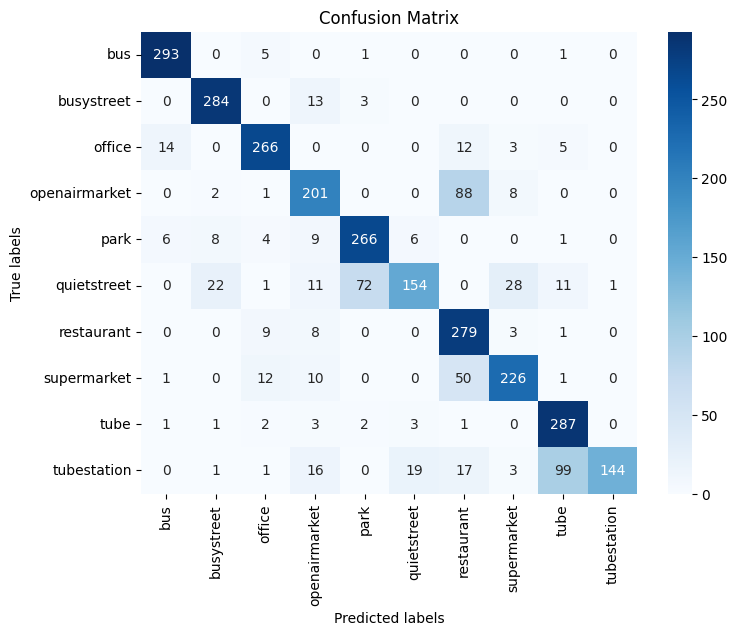

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
classes = scapper_scene_labels


plot_confusion_matrix(labels_array, labels_preds, classes)

In [43]:
#type(convert_outputs(torch.Tensor(all_predictions[0])))
for i in range(len(all_predictions)):
    all_predictions[i] = (convert_outputs(torch.Tensor(all_predictions[i])))
    all_labels[i] = torch.Tensor(all_labels[i])

from torchmetrics import F1Score, Accuracy

accuracy = Accuracy(task='multiclass', num_classes=10)
f1Score = F1Score(task='multiclass', num_classes=10, average='macro')

print(accuracy(torch.Tensor(all_predictions), torch.Tensor(all_labels)))



ValueError: only one element tensors can be converted to Python scalars

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

epochs = 10

for epoch in range(epochs):
    running_loss = 0
    model.train()
    for i, batch in enumerate(train_loader):

        optimizer.zero_grad()
        inputs, labels = batch['data'], label_to_one_hot(batch['scene_label'])
        inputs = inputs.to(device)
        labels = labels.to(device = device, dtype=torch.float)

        outputs, second_last = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

Epoch 1, Loss: 2.227707805785727
Epoch 2, Loss: 1.8756551805962907
Epoch 3, Loss: 1.7171840020950804
Epoch 4, Loss: 1.6200420881839508
Epoch 5, Loss: 1.3975865048296907
Epoch 6, Loss: 1.2634150037106047
Epoch 7, Loss: 1.0371648073196411
Epoch 8, Loss: 0.9583680065388375
Epoch 9, Loss: 0.7565000646925987
Epoch 10, Loss: 0.594993031088342


In [22]:
i = 2569
sample = os.path.join(SCAPPER_AUD_DIR, scapper_df['audio_fileNames'][i])
audio = audio_utils.load_audio_from_file(sample)
spec = audio_utils.get_log_melSpectrogram(audio)

model = model.cpu()
with torch.inference_mode():
    model.eval()
    output, second_last = model(spec.unsqueeze(0))
    print(output.shape)
    print(convert_outputs(torch.sigmoid(output)))
    #print(torch.argmax(output))

print(scapper_df['acoustic_scene_label'][i], scapper_scene_labels[torch.argmax(output)])


torch.Size([1, 10])
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tube tube


In [18]:
torch.save(model.state_dict(), 'ASC_Model00_00_statedict.pt')

In [86]:
scapper_scene_labels

['bus',
 'busystreet',
 'office',
 'openairmarket',
 'park',
 'quietstreet',
 'restaurant',
 'supermarket',
 'tube',
 'tubestation']

In [20]:
for i in range(0,5):
    print(label_to_one_hot([scapper_dataset[i]['scene_label']]))

[[1 0 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0 0]]
